# Imports

In [90]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline
%reload_ext watermark
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from IPython.display import display
import sklearn as sk
import sklearn.neural_network as sknn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



# Data

In this section we load both datasets we use, COVID-19 dataset and countries population dataset , clean the data and add some new columns.  

The datasets we use are:

* https://www.kaggle.com/imdevskp/corona-virus-report for the COVID-19 dataset

* https://www.kaggle.com/tanuprabhu/population-by-country-2020 for population information per country


## COVID-19 Dataset

In [91]:
# Loading datasets

full_table = pd.read_csv('datasets/covid_19_clean_complete.csv', 
                          na_values=['NaN'],
                          parse_dates=['Date'])

# Adding Active cases column
full_table['Active'] = (full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']).apply(lambda x: x if x >= 0 else 0)

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed','Deaths','Recovered','Active']] = full_table[['Confirmed','Deaths','Recovered','Active']].fillna(0)

full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
21306,,Finland,64.0000,26.0000,2020-04-11,2905,49,300,2556
19478,,Iran,32.0000,53.0000,2020-04-04,55743,3452,19736,32555
15073,,Grenada,12.1165,-61.6790,2020-03-18,0,0,0,0
11096,Diamond Princess,Canada,0.0000,0.0000,2020-03-03,0,0,0,0
2747,,Ecuador,-1.8312,-78.1834,2020-02-01,0,0,0,0
18653,,Eswatini,-26.5225,31.4659,2020-04-01,9,0,0,9


## Population Dataset


In [92]:
pop_table = pd.read_csv('datasets/population_by_country_2020.csv',
                        na_values=['N.A.'])


# Selecting only the Country and Population columns
pop_table = pop_table.iloc[:,[0,1,4,9]]



# Renaming columns
pop_table.columns = ['Country/Region', 'Population', 'Population Density (P/Km²)','Urban Population %']

# Most of the entries with urban population as NaN in the population dataset that we are going to use have 100% as of 2020
pop_table[['Urban Population %']] = pop_table[['Urban Population %']].fillna('100 %')
pop_table['Urban Population %'] = pop_table['Urban Population %'].map(lambda x: int(x.split(' ')[0]))


In [93]:
pop_table.info()
pop_table.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country/Region              235 non-null    object
 1   Population                  235 non-null    int64 
 2   Population Density (P/Km²)  235 non-null    int64 
 3   Urban Population %          235 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ KB


Country/Region                0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

## Removing ship data

The dataset also includes data from the various ships that had COVID19 outbreaks. Since we only need the information per country we removed it from the dataset.

In [94]:
# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# dropping ship rows 
full_table = full_table[~(ship_rows)]

ship.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
23143,,Diamond Princess,0.0000,0.0000,2020-04-18,712,13,644,55
6978,,Diamond Princess,0.0000,0.0000,2020-02-17,454,0,0,454
29717,Grand Princess,Canada,37.6489,-122.6655,2020-05-13,13,0,0,13
19331,,MS Zaandam,0.0000,0.0000,2020-04-03,9,2,0,7
5816,,MS Zaandam,0.0000,0.0000,2020-02-12,0,0,0,0
29401,,MS Zaandam,0.0000,0.0000,2020-05-11,9,2,0,7


## Fixing country names


### Fixing mismatched names between datasets

Here we manually set the names so that the join between datasets works.


In [95]:
fix_name_only = {
    'Sao Tome & Principe': 'Sao Tome and Principe',
    "Côte d'Ivoire": "Cote d'Ivoire",
    "United States": "US",
    "Czech Republic (Czechia)": 'Czechia',
    'Myanmar': 'Burma',
    'Taiwan': 'Taiwan*',
    'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
    'Macao' : 'Macau'
}

for original,new in fix_name_only.items():
    full_table.loc[full_table['Country/Region'] == new, 'Country/Region'] = original
    full_table.loc[full_table['Province/State'] == new, 'Province/State'] = original

missing_countries = set(full_table['Country/Region']).difference(set(pop_table['Country/Region']))

# # print(sorted(pop_table['Country/Region'].unique()))
# if len(missing_countries) != 0:
#     print(missing_countries)


### Replacing Country/Region with Province/State

The population dataset has entries for autonomous regions, for example Greenland. Here we rewrite the Country/Region column with the Province/State name so we can easily join the population dataset. For example, Greenland exists in the population dataset so what we do is replace Denmark (the Country column of Greenland) with Greenland.

In [96]:

province_set = set(full_table['Province/State']).intersection(set(pop_table['Country/Region']))

no_data = set(['Saint Vincent and the Grenadines','Kosovo','Congo','West Bank and Gaza'])

for province in province_set:
    if province in no_data:
        continue
    full_table.loc[ full_table['Province/State'] == province,'Country/Region'] = province 



In [97]:
# Check for null values
full_table.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
dtype: int64

## Grouping data

Here we are grouping data by Date and Country so we can add population and cases per million afterwards.

### Group by Country

In [98]:
full_grouped = full_table.groupby(['Country/Region','Lat','Long','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()
full_grouped_nolat = full_table.groupby(['Country/Region','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()

full_grouped.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0


### Adding population
In this section, we merge both datasets by Country/Region.

In [99]:
full_grouped = pd.merge(full_grouped,pop_table,on=['Country/Region'])
full_grouped_nolat = pd.merge(full_grouped_nolat,pop_table,on=['Country/Region'])

full_grouped

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25
...,...,...,...,...,...,...,...,...,...,...,...
31995,Zimbabwe,-20.0,30.0,2020-05-21,51,4,18,29,14818157,38,38
31996,Zimbabwe,-20.0,30.0,2020-05-22,51,4,18,29,14818157,38,38
31997,Zimbabwe,-20.0,30.0,2020-05-23,56,4,18,34,14818157,38,38
31998,Zimbabwe,-20.0,30.0,2020-05-24,56,4,25,27,14818157,38,38


### Calculating new cases per day

To calculate the number of

In [100]:
# Dataframe with latitude and longitude
temp = full_grouped.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan


temp.columns = ['Country/Region', 'Date','New cases', 'New deaths', 'New recovered']


full_grouped = pd.merge(full_grouped,temp, on=['Country/Region', 'Date'])

full_grouped = full_grouped.fillna(0)

full_grouped[['New cases','New deaths','New recovered']] = full_grouped[['New cases','New deaths','New recovered']].astype('int64')

#############################################################################################################################
# # Dataset with no lat and long

temp = full_grouped_nolat.groupby(['Country/Region', 'Date' ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']

full_grouped_nolat = pd.merge(full_grouped_nolat,temp, on=['Country/Region', 'Date'])

full_grouped_nolat = full_grouped_nolat.fillna(0)

full_grouped_nolat[['New cases','New deaths','New recovered']] = full_grouped_nolat[['New cases','New deaths','New recovered']].astype('int64')


### World Data

In [101]:
world_data = full_grouped.groupby(['Date'])['Confirmed','Deaths','Recovered','Active','Population'].sum().reset_index()
world_data.loc[world_data['Date'] == world_data['Date'].max()]
world_data.head()
world_pop_total = world_data['Population'].max()

In [102]:
# Check information on types and null values
full_grouped.info()
full_grouped.loc[full_grouped['Urban Population %'].isnull()]['Country/Region'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              32000 non-null  object        
 1   Lat                         32000 non-null  float64       
 2   Long                        32000 non-null  float64       
 3   Date                        32000 non-null  datetime64[ns]
 4   Confirmed                   32000 non-null  int64         
 5   Deaths                      32000 non-null  int64         
 6   Recovered                   32000 non-null  int64         
 7   Active                      32000 non-null  int64         
 8   Population                  32000 non-null  int64         
 9   Population Density (P/Km²)  32000 non-null  int64         
 10  Urban Population %          32000 non-null  int64         
 11  New cases                   32000 non-null  int64     

array([], dtype=object)

In [103]:
full_grouped.sample(6)

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered
7069,Chad,15.4542,18.7322,2020-03-31,7,0,0,7,16324440,13,23,2,0,0
23044,Nepal,28.1667,84.2500,2020-03-06,1,0,1,0,29027347,203,21,0,0,0
28282,Sri Lanka,7.0000,81.0000,2020-02-23,1,0,1,0,21395196,341,18,0,0,0
28753,Switzerland,46.8182,8.2275,2020-01-25,0,0,0,0,8641786,219,74,0,0,0
20522,Madagascar,-18.7669,46.8691,2020-02-13,0,0,0,0,27539106,48,39,0,0,0
27541,Slovenia,46.1512,14.9955,2020-03-03,0,0,0,0,2078881,103,55,0,0,0


### Calculating Cases per Million of People




In [104]:

def calc_permillion(df):
    df['Confirmed per million'] = round((df['Confirmed'] / df['Population']) * 1000000)
    df['Deaths per million']    = round((df['Deaths'] / df['Population']) * 1000000)
    df['Recovered per million'] = round((df['Recovered'] / df['Population']) * 1000000)
    df['Active per million']    = round((df['Active'] / df['Population']) * 1000000)
    return df

def calc_permillion_world():
    world_data['Confirmed per million'] = round((world_data['Confirmed'] / world_data['Population']) * 1000000)
    world_data['Deaths per million']    = round((world_data['Deaths'] / world_data['Population']) * 1000000)
    world_data['Recovered per million'] = round((world_data['Recovered'] / world_data['Population']) * 1000000)
    world_data['Active per million']    = round((world_data['Active'] / world_data['Population']) * 1000000)



per_million = calc_permillion(full_grouped)
per_million_nolat = calc_permillion(full_grouped_nolat)

per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0


### Value Truncation

Since the COVID-19 dataset only has data from  22nd of January of 2020 onwards, we will define Date from here moving foward as days since the 22nd of January of 2020.

In [105]:
per_million['Date'].min()

Timestamp('2020-01-22 00:00:00')

This function does that:

In [106]:
def daysSinceJan(d):
    return d.toordinal() - datetime(2020,1,20).toordinal()

def revertdaysSince(d):
    return datetime(2020,1,20) + timedelta(days=d)

In [107]:
per_million_nolat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25125 entries, 0 to 25124
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              25125 non-null  object        
 1   Date                        25125 non-null  datetime64[ns]
 2   Confirmed                   25125 non-null  int64         
 3   Deaths                      25125 non-null  int64         
 4   Recovered                   25125 non-null  int64         
 5   Active                      25125 non-null  int64         
 6   Population                  25125 non-null  int64         
 7   Population Density (P/Km²)  25125 non-null  int64         
 8   Urban Population %          25125 non-null  int64         
 9   New cases                   25125 non-null  int64         
 10  New deaths                  25125 non-null  int64         
 11  New recovered               25125 non-null  int64     

In [108]:
per_million['Days Since Jan'] = per_million['Date'].map(daysSinceJan)

per_million_nolat['Days Since Jan'] = per_million['Date'].map(daysSinceJan)

In [109]:
per_million =  per_million.sort_values(['Date','Country/Region'],ascending=[True, True])
per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan
0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2
125,Albania,41.1533,20.1683,2020-01-22,0,0,0,0,2878420,105,63,0,0,0,0.0,0.0,0.0,0.0,2
250,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0,43685618,18,73,0,0,0,0.0,0.0,0.0,0.0,2
375,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0,77240,164,88,0,0,0,0.0,0.0,0.0,0.0,2
500,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0,32644783,26,67,0,0,0,0.0,0.0,0.0,0.0,2


In [110]:
per_million_nolat.isna().sum()

Country/Region                0
Date                          0
Confirmed                     0
Deaths                        0
Recovered                     0
Active                        0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
New cases                     0
New deaths                    0
New recovered                 0
Confirmed per million         0
Deaths per million            0
Recovered per million         0
Active per million            0
Days Since Jan                0
dtype: int64

### Adding population percentage

In [111]:
per_million['Pop %'] = per_million['Population'].apply(lambda x: x/world_pop_total * 100)
per_million_nolat['Pop %'] = per_million_nolat['Population'].apply(lambda x: x/world_pop_total * 100)

In [112]:
full_grouped.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,3
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,4
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,5
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,6


In [113]:
per_million_nolat

,Country/Region,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan,Pop %
0,Afghanistan,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2,0.074890
1,Afghanistan,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,3,0.074890
2,Afghanistan,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,4,0.074890
3,Afghanistan,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,5,0.074890
4,Afghanistan,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,6,0.074890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25120,Zimbabwe,2020-05-21,51,4,18,29,14818157,38,38,3,0,0,3.0,0.0,1.0,2.0,122,0.028643
25121,Zimbabwe,2020-05-22,51,4,18,29,14818157,38,38,0,0,0,3.0,0.0,1.0,2.0,123,0.028643
25122,Zimbabwe,2020-05-23,56,4,18,34,14818157,38,38,5,0,0,4.0,0.0,1.0,2.0,124,0.028643
25123,Zimbabwe,2020-05-24,56,4,25,27,14818157,38,38,0,0,7,4.0,0.0,2.0,2.0,125,0.028643


In [114]:
def removeChinaData(df):
    df = df[full_grouped['Country/Region'] != 'China']

removeChinaData(full_grouped)
removeChinaData(full_grouped_nolat)
removeChinaData(per_million_nolat)
removeChinaData(per_million)

In [115]:
per_million.loc[per_million['Country/Region'] == 'Portugal']

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan,Pop %
25250,Portugal,39.3999,-8.2245,2020-01-22,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,2,0.019721
25251,Portugal,39.3999,-8.2245,2020-01-23,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,3,0.019721
25252,Portugal,39.3999,-8.2245,2020-01-24,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,4,0.019721
25253,Portugal,39.3999,-8.2245,2020-01-25,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,5,0.019721
25254,Portugal,39.3999,-8.2245,2020-01-26,0,0,0,0,10202571,111,66,0,0,0,0.0,0.0,0.0,0.0,6,0.019721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25370,Portugal,39.3999,-8.2245,2020-05-21,29912,1277,6452,22183,10202571,111,66,252,14,0,2932.0,125.0,632.0,2174.0,122,0.019721
25371,Portugal,39.3999,-8.2245,2020-05-22,30200,1289,7590,21321,10202571,111,66,288,12,1138,2960.0,126.0,744.0,2090.0,123,0.019721
25372,Portugal,39.3999,-8.2245,2020-05-23,30471,1302,7705,21464,10202571,111,66,271,13,115,2987.0,128.0,755.0,2104.0,124,0.019721
25373,Portugal,39.3999,-8.2245,2020-05-24,30623,1316,17549,11758,10202571,111,66,152,14,9844,3001.0,129.0,1720.0,1152.0,125,0.019721


In [116]:
per_million_nolat.isna().sum()

Country/Region                0
Date                          0
Confirmed                     0
Deaths                        0
Recovered                     0
Active                        0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
New cases                     0
New deaths                    0
New recovered                 0
Confirmed per million         0
Deaths per million            0
Recovered per million         0
Active per million            0
Days Since Jan                0
Pop %                         0
dtype: int64

# Model Training

## Inputs and outputs

This function will return a pair of inputs and outputs given the country:

In [117]:
def world_train_data(df_full,country=None,out=['Confirmed per million',	'Deaths per million',	'Recovered per million']):
    df = df_full
    input  = ['Date','Population Density (P/Km²)','Urban Population %', 'Pop %']
    if country is not None:
        df = df_full.loc[ df_full['Country/Region'] == country]
        input = ['Date']
    return df[input], df[out]


In [118]:
per_million_nolat.head()

,Country/Region,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,New cases,New deaths,New recovered,Confirmed per million,Deaths per million,Recovered per million,Active per million,Days Since Jan,Pop %
0,Afghanistan,2020-01-22,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,2,0.07489
1,Afghanistan,2020-01-23,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,3,0.07489
2,Afghanistan,2020-01-24,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,4,0.07489
3,Afghanistan,2020-01-25,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,5,0.07489
4,Afghanistan,2020-01-26,0,0,0,0,38742911,60,25,0,0,0,0.0,0.0,0.0,0.0,6,0.07489


In [119]:
def nn_by_country_train(
    country,
    input=['Days Since Jan','Population Density (P/Km²)','Urban Population %','Pop %'],
    out= ['Confirmed per million','Deaths per million','Recovered per million'],
    hidden_layer_sizes=(100,100,100,60,60,60)
):
    df = per_million_nolat.loc[ per_million_nolat['Country/Region'] == country]
    X = df[input].values
    Y = df[out].values
    nn = sknn.MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        alpha=0.00001,
        batch_size='auto',
        max_iter=1000,
        n_iter_no_change=100,
        verbose=4
        )

    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)
    nn.fit(X_train,y_train) # Train the model
    y_pred = nn.predict(X_test)

    nnr2 = nn.score(X_test,y_test) # Calculate R² for the model
    nnmae = mean_absolute_error(y_test,y_pred) # Mean Absolute Error
    nnmse = mean_squared_error(y_test,y_pred)

    print("R2:",nnr2)
    print("MAE:",nnmae)
    print("MSE:",nnmse)

    return nn

In [141]:
def print_graph(world_viz,things = ['Confirmed','Deaths','Recovered'],label='C/D/R',x = 'Date',title='Title'):
    sb.set()

    dd = world_viz.melt([x],var_name=label, value_name='Cases',value_vars=things)


    chart = sb.relplot(x=x,y='Cases',hue=label,data=dd,kind='line')

    chart.set(title=title)
    axs = chart.axes
    chart.fig.autofmt_xdate()
    plt.show()

In [121]:
def print_side(real_data,predict):
    dd = world_viz.melt([x],var_name=label, value_name='Cases',value_vars=things)
    fig, axs = plt.subplots(ncols=2)


In [122]:
def getPredInp(country):
    return [per_million.loc[per_million['Country/Region'] == country]['Population Density (P/Km²)'].max(),
    per_million.loc[per_million['Country/Region'] == country]['Urban Population %'].max(),
    per_million.loc[full_grouped['Country/Region'] == country]['Pop %'].max()]

# per_million.loc[per_million['Country/Region'] == 'Portugal'].groupby(['Lat','Long']).size()

In [145]:
def print_predict(model,country,minprev=0,offset=10,maxprev=daysSinceJan(datetime.now().date() - timedelta(days=1))):

    country_pop = per_million_nolat.loc[per_million_nolat['Country/Region'] == country]['Population'].max()
    ip = []

    for dat in range(minprev,maxprev+offset+1): # Predict from 0 to 155 days from January 1st 2020
        ip.append([dat, *getPredInp(country)]) # Hard Coded Pop Density, Urban Pop %, Latitude and Longitude

    out = nn.predict(ip)

    nl = []

    for i,o in zip(ip,out):
        nl.append([*i,*o])

    futurepredict = pd.DataFrame(nl,columns=['Date','Population Density (P/Km²)','Urban Population %',"Pop %",'Confirmed','Deaths','Recovered'])

    futurepredict['Confirmed'] = futurepredict['Confirmed'].map(lambda x: round((x/1000000) * country_pop))
    futurepredict['Recovered'] = futurepredict['Recovered'].map(lambda x: round((x/1000000) * country_pop))
    futurepredict['Deaths'] = futurepredict['Deaths'].map(lambda x: round((x/1000000) * country_pop) )

    futurepredict['Date'] = futurepredict['Date'].map(revertdaysSince) 
    predict = futurepredict.loc[(futurepredict['Date'] >= revertdaysSince(maxprev - 30)) & (futurepredict['Date'] <= revertdaysSince(maxprev + offset))]


    print_graph(per_million_nolat.loc[(per_million_nolat['Country/Region'] == country) & (per_million_nolat['Date'] >= revertdaysSince(maxprev-30))],['Confirmed',  'Deaths','Recovered'], title='Real data')
    print_graph(predict,['Confirmed','Deaths','Recovered'],x='Date', title="Future prediction")

    print_graph(futurepredict.loc[(futurepredict['Date'] <= revertdaysSince(maxprev))],['Confirmed','Deaths','Recovered'],x='Date', title="MLPRegressor Predict of  Data")
    print_graph(per_million_nolat.loc[per_million_nolat['Country/Region'] == country],['Confirmed','Deaths','Recovered'], title='Real Data')



In [149]:
country = 'United States'
nn = nn_by_country_train(country)


79089
Iteration 415, loss = 70.50467767
Iteration 416, loss = 70.01504489
Iteration 417, loss = 69.97157428
Iteration 418, loss = 70.46821811
Iteration 419, loss = 70.97247923
Iteration 420, loss = 71.39002790
Iteration 421, loss = 70.87278808
Iteration 422, loss = 70.17471546
Iteration 423, loss = 69.49575447
Iteration 424, loss = 69.44189761
Iteration 425, loss = 69.61883919
Iteration 426, loss = 70.08443063
Iteration 427, loss = 70.03021709
Iteration 428, loss = 69.76945562
Iteration 429, loss = 69.27428496
Iteration 430, loss = 68.92637813
Iteration 431, loss = 68.92374466
Iteration 432, loss = 68.95977723
Iteration 433, loss = 69.07443463
Iteration 434, loss = 68.96377093
Iteration 435, loss = 68.81513101
Iteration 436, loss = 68.53613264
Iteration 437, loss = 68.42521076
Iteration 438, loss = 68.36593618
Iteration 439, loss = 68.34736120
Iteration 440, loss = 68.44450594
Iteration 441, loss = 68.36588580
Iteration 442, loss = 68.31356912
Iteration 443, loss = 68.09125643
Iteratio

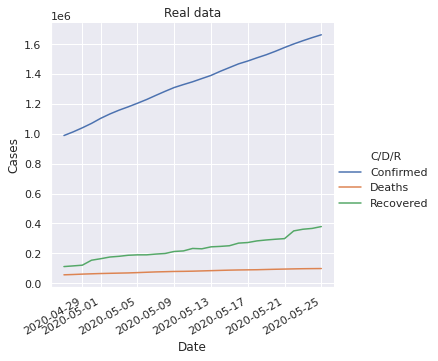

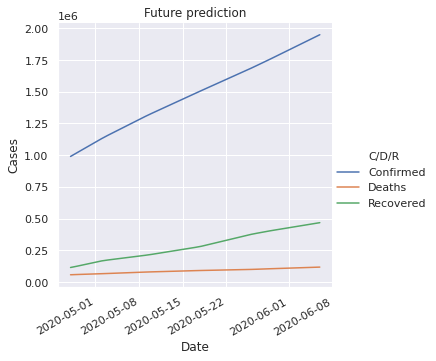

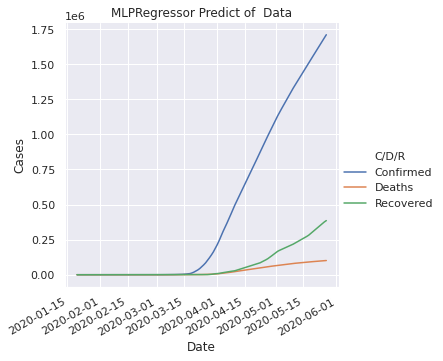

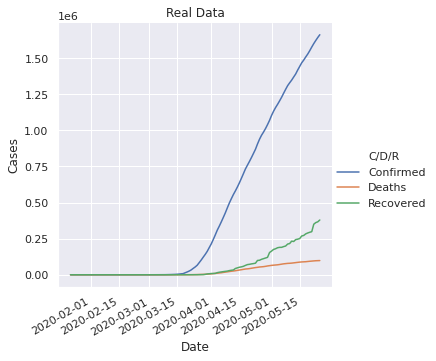

In [150]:
print_predict(nn,country)